## Estimate how many copies of a game has sold on steam on reviews
Steam sale data is not public.  Historically, game marketing companies have used a metric called the Boxleiter number which was most recently updated in 2018 [3].  In October 2019, Steam introduced a 'would you like to review this?' button directly to a games launch page.  This button's existence would imply that games with higher reviews would also mean that there are more sales.

The sample dataset for the number of people who own a game come from SteamSpy, a third party source.  So any analysis made should be taken with a grain of salt.

In [1]:
# imports and setup

import scipy as sc
import numpy as np
from scipy.stats import norm
import seaborn as sns

import pandas as pd
import statsmodels.formula.api as sm
from sklearn import linear_model

import matplotlib.pyplot as plt
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6)

from sklearn.model_selection import train_test_split
from statsmodels.tools import add_constant
import statsmodels.api as sm1 #for multiple regression

In [2]:
df = pd.read_csv('data/clean_steam_general.csv')

In [3]:
# correlation plot seaborn
df.head()

,QueryName,ResponseName,ReleaseDate,RequiredAge,Metacritic,RecommendationCount,ScreenshotCount,SteamSpyOwners,SteamSpyOwnersVariance,SteamSpyPlayersEstimate,...,PurchaseAvail,SubscriptionAvail,PlatformWindows,PlatformLinux,PlatformMac,GenreIsEarlyAccess,GenreIsFreeToPlay,PriceCurrency,PriceInitial,PriceFinal
0,Counter-Strike,Counter-Strike,Nov 1 2000,0,88,68991,13,13033334,92789,9140731,...,True,False,True,True,True,False,False,USD,9.99,9.99
1,Team Fortress Classic,Team Fortress Classic,Apr 1 1999,0,0,2439,5,5399140,60368,753627,...,True,False,True,True,True,False,False,USD,4.99,4.99
2,Day of Defeat,Day of Defeat,May 1 2003,0,79,2319,5,7621102,71499,1709740,...,True,False,True,True,True,False,False,USD,4.99,4.99
3,Deathmatch Classic,Deathmatch Classic,Jun 1 2001,0,0,888,4,7498965,70936,789676,...,True,False,True,True,True,False,False,USD,4.99,4.99
4,Half-Life: Opposing Force,Half-Life: Opposing Force,Nov 1 1999,0,0,2934,5,5399499,60370,705741,...,True,False,True,True,True,False,False,USD,4.99,4.99


In [4]:
# we don't neccessarily care about the name of the game
df_sales = df[['Metacritic', 'RecommendationCount', 'SteamSpyOwners','SteamSpyOwnersVariance', 'SteamSpyPlayersEstimate', 'SteamSpyPlayersVariance', 'IsFree', 'PurchaseAvail', 'PlatformWindows', 'PlatformLinux', 'PlatformMac', 'GenreIsEarlyAccess', 'GenreIsFreeToPlay', 'PriceInitial', 'PriceFinal']]
df_sales.head()

,Metacritic,RecommendationCount,SteamSpyOwners,SteamSpyOwnersVariance,SteamSpyPlayersEstimate,SteamSpyPlayersVariance,IsFree,PurchaseAvail,PlatformWindows,PlatformLinux,PlatformMac,GenreIsEarlyAccess,GenreIsFreeToPlay,PriceInitial,PriceFinal
0,88,68991,13033334,92789,9140731,78136,False,True,True,True,True,False,False,9.99,9.99
1,0,2439,5399140,60368,753627,22699,False,True,True,True,True,False,False,4.99,4.99
2,79,2319,7621102,71499,1709740,34145,False,True,True,True,True,False,False,4.99,4.99
3,0,888,7498965,70936,789676,23235,False,True,True,True,True,False,False,4.99,4.99
4,0,2934,5399499,60370,705741,21968,False,True,True,True,True,False,False,4.99,4.99


In [5]:
# remove any outliers in metacritic score, recommendationcount, steamspyowners, steamspyplayerestimate

#check if the datatypes are correct
print(df_sales.dtypes[['Metacritic', 'RecommendationCount', 'SteamSpyOwners','SteamSpyOwnersVariance', 'SteamSpyPlayersEstimate', 'SteamSpyPlayersVariance', 'IsFree', 'PurchaseAvail', 'PlatformWindows', 'PlatformLinux', 'PlatformMac', 'GenreIsEarlyAccess', 'GenreIsFreeToPlay', 'PriceInitial', 'PriceFinal']])
#df_sales['ResponseName'] = df_sales['ResponseName'].astype(str) 

# keep only the ones that are within +3 to -3 standard deviations in the columns 'Metacritic', 'RecommendationCount', 'SteamSpyOwners', 'SteamSpyPlayersEstimate', 
df_sales = df_sales[np.abs(df_sales['Metacritic']-df_sales['Metacritic'].mean()) <= (3*df_sales['Metacritic'].std())]
df_sales = df_sales[np.abs(df_sales['RecommendationCount']-df_sales['RecommendationCount'].mean()) <= (3*df_sales['RecommendationCount'].std())]
df_sales = df_sales[np.abs(df_sales['SteamSpyOwners']-df_sales['SteamSpyOwners'].mean()) <= (3*df_sales['SteamSpyOwners'].std())]
df_sales = df_sales[np.abs(df_sales['SteamSpyPlayersEstimate']-df_sales['SteamSpyPlayersEstimate'].mean()) <= (3*df_sales['SteamSpyPlayersEstimate'].std())]

Metacritic                   int64
RecommendationCount          int64
SteamSpyOwners               int64
SteamSpyOwnersVariance       int64
SteamSpyPlayersEstimate      int64
SteamSpyPlayersVariance      int64
IsFree                        bool
PurchaseAvail                 bool
PlatformWindows               bool
PlatformLinux                 bool
PlatformMac                   bool
GenreIsEarlyAccess            bool
GenreIsFreeToPlay             bool
PriceInitial               float64
PriceFinal                 float64
dtype: object


## EDA

In [6]:
# EDA of sales data
df_sales.describe()

,Metacritic,RecommendationCount,SteamSpyOwners,SteamSpyOwnersVariance,SteamSpyPlayersEstimate,SteamSpyPlayersVariance,PriceInitial,PriceFinal
count,12790.000000,12790.000000,1.279000e+04,12790.000000,12790.000000,12790.000000,12790.000000,12790.000000
mean,10.383112,314.277561,5.945671e+04,4088.007819,30504.859812,2894.905864,8.848099,8.503396
std,25.335544,1259.770790,1.358313e+05,4899.656060,69730.264776,3545.782653,14.216930,13.508905
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,7.170000e+02,858.000000,533.000000,740.000000,1.990000,1.990000
50%,0.000000,0.000000,8.250000e+03,2377.000000,3408.000000,1567.000000,5.990000,4.990000
75%,0.000000,191.000000,4.555500e+04,5586.000000,20805.000000,3775.000000,9.990000,9.990000
max,94.000000,44352.000000,1.635130e+06,33395.000000,484961.000000,18216.000000,449.990000,449.990000


In [7]:
corr = df_sales.corr()
print(corr)

                         Metacritic  RecommendationCount  SteamSpyOwners  \
Metacritic                 1.000000             0.206436        0.381336   
RecommendationCount        0.206436             1.000000        0.380106   
SteamSpyOwners             0.381336             0.380106        1.000000   
SteamSpyOwnersVariance     0.442308             0.385891        0.919436   
SteamSpyPlayersEstimate    0.386289             0.498162        0.888300   
SteamSpyPlayersVariance    0.444223             0.454009        0.851495   
IsFree                    -0.073051             0.038733        0.181196   
PurchaseAvail              0.172834             0.055375        0.023185   
PlatformWindows            0.005125             0.002142        0.002527   
PlatformLinux              0.039227             0.031120        0.016672   
PlatformMac                0.055040             0.040123        0.052537   
GenreIsEarlyAccess        -0.144054            -0.029138       -0.090078   
GenreIsFreeT

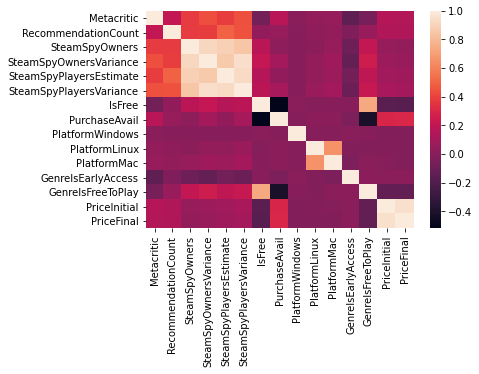

In [8]:
#correlation heatmap
#the darker the color the worse the correlation
sns.heatmap(corr)
plt.show()

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6

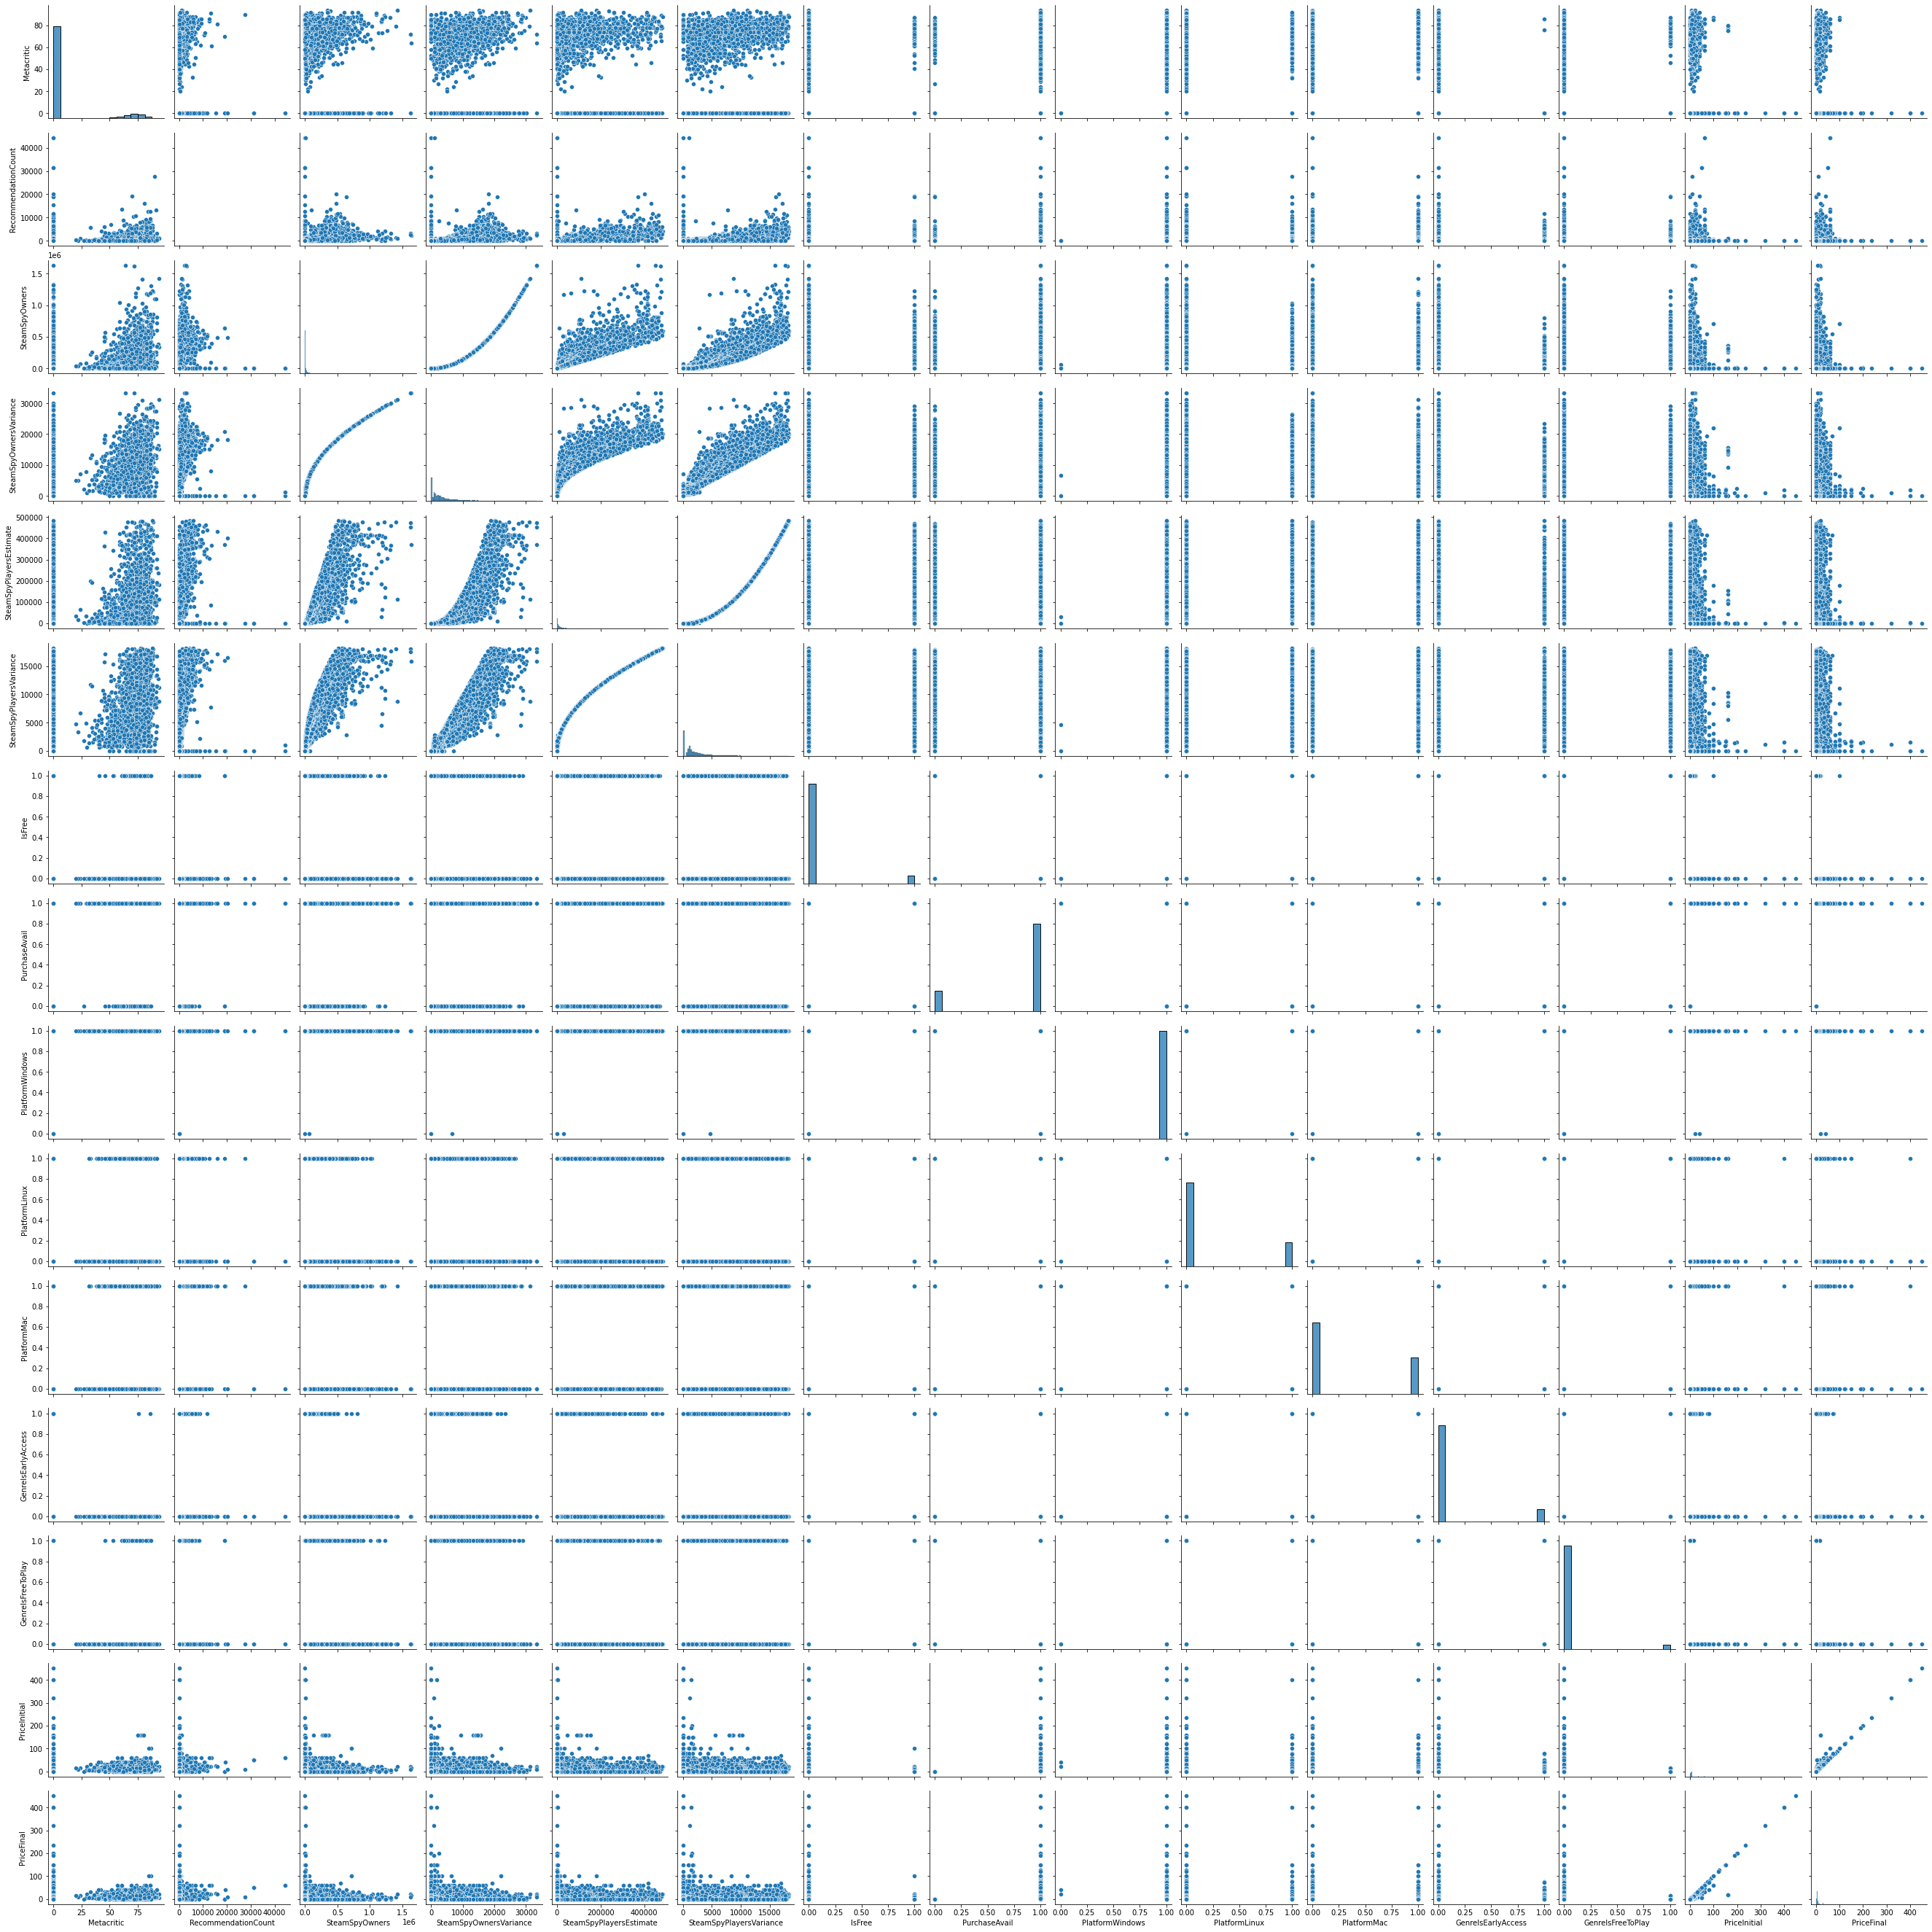

In [23]:

scatter_matrix = sns.pairplot(df_sales[['Metacritic', 'RecommendationCount', 'SteamSpyOwners','SteamSpyOwnersVariance', 'SteamSpyPlayersEstimate', 'SteamSpyPlayersVariance', 'IsFree', 'PurchaseAvail', 'PlatformWindows', 'PlatformLinux', 'PlatformMac', 'GenreIsEarlyAccess', 'GenreIsFreeToPlay', 'PriceInitial', 'PriceFinal']])
plt.savefig('sales_scatter.jpg') #saving plot since this takes awhile to run
# warning is just numpy converting the boolean to [0,1]

In [9]:
# fit regression model with statsmodel
boxleiter = sm.ols(formula="SteamSpyOwners ~ RecommendationCount", data=df_sales).fit()
boxleiter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         SteamSpyOwners   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     2160.
Date:                Wed, 24 Mar 2021   Prob (F-statistic):               0.00
Time:                        09:57:21   Log-Likelihood:            -1.6832e+05
No. Observations:               12790   AIC:                         3.366e+05
Df Residuals:                   12788   BIC:                         3.367e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            4.658e+04   1145.007     40.678      0.000    4.43e+04    4.88e+04
RecommendationCount    40.9839      0.882     46.472      0.000      39.255      42.713
==============================================================================
Omnibus:                     9926.679   Durbin-Watson:                   1.264
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           803326.461
Skew:                           3.123   Prob(JB):                         0.00
Kurtosis:                      41.320   Cond. No.                     1.34e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

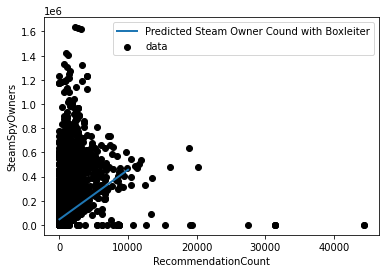

{'Intercept': 46576.38971946707, 'RecommendationCount': 40.983893334929554}


In [25]:
par1 = dict(boxleiter.params)

plt.scatter(df_sales['RecommendationCount'],df_sales['SteamSpyOwners'],color='black',label="data")
x = np.linspace(0, 10000)
y1 = par1["Intercept"] + par1['RecommendationCount']*x

plt.plot(x,y1,label="Predicted Steam Owner Cound with Boxleiter",linewidth=2)
plt.legend()
plt.xlabel('RecommendationCount'); plt.ylabel('SteamSpyOwners')
#plt.ylim((0,50))
plt.show()
print(par1)

## Beat the Boxleiter number




[12788, 4289, 2865]


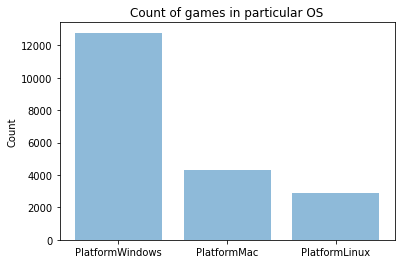

In [21]:
#bar chart
windows_count = df_sales['PlatformWindows'].sum()
mac_count = df_sales['PlatformMac'].sum()
linux_count = df_sales['PlatformLinux'].sum()
x = ('PlatformWindows', 'PlatformMac', 'PlatformLinux')
x_pos = np.arange(len(x))
counts = [windows_count,mac_count, linux_count]
print(counts)

plt.bar(x_pos,counts, align='center', alpha=0.5)
plt.xticks(x_pos, x)
plt.ylabel('Count')
plt.title('Count of games in particular OS')
plt.show()

Text(0.5, 1.0, 'Prop Type vs. TotSqf')

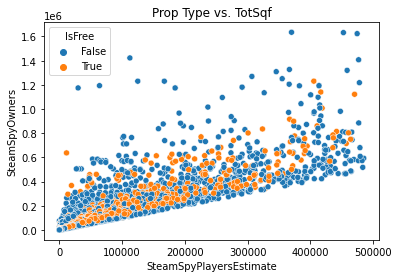

In [11]:
#do something with scatterplots and the booleans just to see if there is something there
sns.scatterplot(data=df_sales, x="SteamSpyPlayersEstimate", y="SteamSpyOwners", hue='IsFree')
plt.xlabel('SteamSpyPlayersEstimate')
plt.ylabel('SteamSpyOwners')
plt.title('Prop Type vs. TotSqf')

Text(0.5, 1.0, 'Prop Type vs. TotSqf')

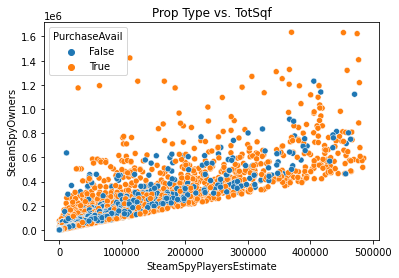

In [22]:
sns.scatterplot(data=df_sales, x="SteamSpyPlayersEstimate", y="SteamSpyOwners", hue='PurchaseAvail')
plt.xlabel('SteamSpyPlayersEstimate')
plt.ylabel('SteamSpyOwners')
plt.title('Prop Type vs. TotSqf')

Text(0.5, 1.0, 'Prop Type vs. TotSqf')

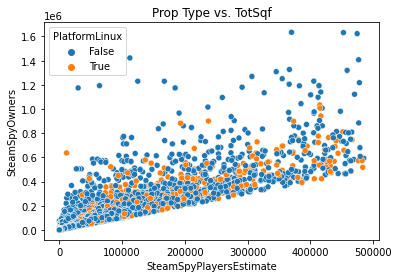

In [28]:
sns.scatterplot(data=df_sales, x="SteamSpyPlayersEstimate", y="SteamSpyOwners", hue='PlatformLinux')
plt.xlabel('SteamSpyPlayersEstimate')
plt.ylabel('SteamSpyOwners')
plt.title('Prop Type vs. TotSqf')

Text(0.5, 1.0, 'Prop Type vs. TotSqf')

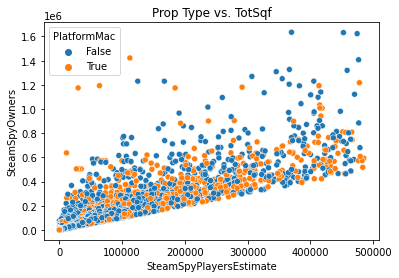

In [29]:
sns.scatterplot(data=df_sales, x="SteamSpyPlayersEstimate", y="SteamSpyOwners", hue='PlatformMac')
plt.xlabel('SteamSpyPlayersEstimate')
plt.ylabel('SteamSpyOwners')
plt.title('Prop Type vs. TotSqf')

Text(0.5, 1.0, 'Prop Type vs. TotSqf')

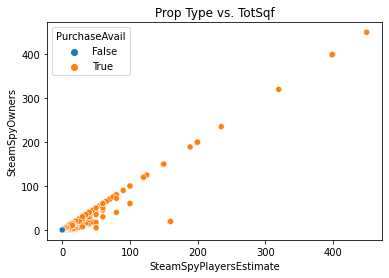

In [27]:
#just to show that PriceInitial and PriceFinal can be used interchangably
sns.scatterplot(data=df_sales, x="PriceInitial", y="PriceFinal", hue='PurchaseAvail')
plt.xlabel('SteamSpyPlayersEstimate')
plt.ylabel('SteamSpyOwners')
plt.title('Prop Type vs. TotSqf')

Text(0.5, 1.0, 'Prop Type vs. TotSqf')

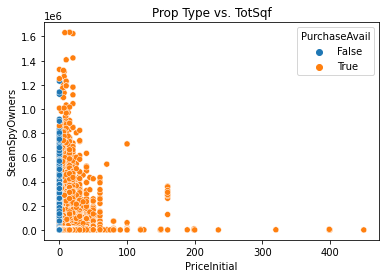

In [30]:
#just to show that PriceInitial and PriceFinal can be used interchangably
sns.scatterplot(data=df_sales, x="PriceInitial", y="SteamSpyOwners", hue='PurchaseAvail')
plt.xlabel('PriceInitial')
plt.ylabel('SteamSpyOwners')
plt.title('Prop Type vs. TotSqf')

Sources:

[1] https://newsletter.gamediscover.co/p/how-that-game-sold-on-steam-using

[2] http://greyaliengames.com/blog/how-to-estimate-how-many-sales-a-steam-game-has-made/

[3] https://www.gamasutra.com/blogs/JakeBirkett/20180504/317366/Using_Steam_reviews_to_estimate_sales.php